In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import sys
#sys.path.append("../../")

from utils.lidar_simulation import *
from utils.nh_seq_util_functions import nh_normalize, nh_apply_action
from utils.lidar_visualizer_patrick import BeamDataVisualizer

In [2]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
print(var.pdf([1,1]))

var2 = multivariate_normal(mean=[3,5], cov=[[1,0],[0,1]])
print(var2.pdf([2,2]))

0.05854983152431917
0.0010723775711956546


In [3]:
def plot_env(text, samples, data_dict, plot_beams, beam_alpha):
    image_path = ""

    bdv_gt = BeamDataVisualizer()
    fig_env_pred = bdv_gt.visualize_loss_environment(
        text, 
        data_dict['x'], 
        data_dict['y'], 
        data_dict['t'], 
        data_dict['si'], 
        image_path, 
        samples, 
        "mse_loss", 
        True,
        plot_beams=plot_beams,
        beam_alpha=beam_alpha,
        connected=True
    )

In [4]:
world_bounds = np.array([[
    [1, 1], 
    [10, 10]
]])

obstacle_bounds = np.array([
    # Obstacle 1
    [[ 8.91985225,  3.84545202],
     [10.66074355,  4.99807121]],
    # Obstacle 2
    [[3.63246185, 1.09008461],
     [4.11128521, 3.03555758]],
    # Obstacle 3
    [[9.43293506, 2.21096876],
     [9.92049135, 4.53472772]],
    # Obsatcle 4
    [[6.94135996, 6.35929963],
     [7.20650368, 7.51843864]],
    # Obstacle 5
    [[1.78852858, 8.83265186],
     [3.30866274, 8.83481765]],
    # Obstacle 6
    [[5.94550616, 6.42045643],
     [8.13677819, 6.57786723]],
    # Obstacle 7
    [[4.46677218, 5.2867644 ],
     [5.4343571 , 6.29994598]],
    # Obstacle 8
    [[7.56080683, 4.1982659 ],
     [9.89202105, 5.45710442]],
    # Obstacle 9
    [[ 2.31954943,  9.68308763],
     [ 2.44298565, 10.1775785 ]],
    # Obstacle 10
    [[0.86895121, 4.83750394],
     [2.69494379, 5.59028893]]
])

In [12]:
config_dict = {
    "Action_params": {
        "relative_x_offset_mean": 0.05,
        "relative_x_offset_std": 0.001,
        "relative_y_offset": 0.01,
        "relative_y_offset_std": 0.001,
        "theta_offset_low":  -30,
        "theta_offset_high": 30,
        "number_of_actions": 1
    },
    "Sequence_params": {
        "number_of_states": 1000
    },
    "Sensor_params": {
        "num_rays": 200,
        "fov": 180
    },
    "seed": 420

}

In [13]:
start_pose = np.array([5, 4, np.deg2rad(10)])

In [ ]:
def calc_dist(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    return np.sqrt(((b-a)**2).sum(-1))   # Euclidian

## Action specific
def sample_actions_magnitudes(n_actions: int, rng, action_params: dict, magnitudes: np.ndarray, current_pose: np.ndarray) -> np.ndarray:
    ray_angles = np.linspace(current_pose[-1]-(torch.pi/2), current_pose[-1]+(torch.pi/2), 200)
    magnitudes[:50] = 0
    magnitudes[-50:] = 0
    magnitudes[magnitudes<0.5] = 0
    print("magnitudes too small: ", magnitudes<0.2)
    ray_weights = torch.nn.functional.softmax(torch.from_numpy(magnitudes)*0.5)

    #action_angle = (ray_angles*ray_weights).sum()

    direction_idx = rng.choice(200, 1, p=ray_weights)
    action_angle = ray_angles[direction_idx].squeeze()
    print("action_angle: ", action_angle)

    if magnitudes.sum() == 0:
        action_length = torch.tensor([0])
    else:
        action_length = rng.normal(loc=action_params["relative_x_offset_mean"], scale=action_params["relative_x_offset_std"], size=n_actions)

    action_vector = np.array(
        [
            np.cos(action_angle), 
            np.sin(action_angle)
        ]
    ).squeeze()

    pose_vector = np.array(
        [
            np.cos(current_pose[-1]), 
            np.sin(current_pose[-1])
        ]
    )
    
    print("pose_vector: ", pose_vector.shape)
    print("action_vector: ", action_vector.shape)

    cross_product = np.cross(pose_vector, action_vector)

    if cross_product < -1:
        cross_product = -1
    elif cross_product > 1:
        cross_product = 1

    print("cross: ", cross_product)

    angle_diff = np.arcsin(cross_product)
    #action_length = relative_x_offset / np.cos(angle_diff)
    relative_x_offset = np.cos(angle_diff) * action_length[:,None]
    relative_y_offset = np.sin(angle_diff) * action_length[:,None]
    
    #relative_y_offset = rng.uniform(low=-action_params["relative_y_offset"], high=action_params["relative_y_offset"], size=n_actions)[:,None]
    #relative_y_offset = (rng.beta(alpha, beta, n_actions)[:,None] * (action_params["relative_y_offset"] - (-action_params["relative_y_offset"]))) + (-action_params["relative_y_offset"])

    print("relative_y_offset: ", relative_y_offset)
    print("relative_x_offset: ", relative_x_offset)

    low_array = np.zeros(n_actions)
    high_array = np.zeros(n_actions)

    right_turn_ids = np.where(relative_y_offset < 0)[0]
    left_turn_ids = np.where(relative_y_offset >= 0)[0]

    low_array[right_turn_ids] = np.deg2rad(action_params["theta_offset_low"])
    high_array[left_turn_ids] = np.deg2rad(action_params["theta_offset_high"])
    
    theta_offset = rng.uniform(low=low_array, high=high_array, size=n_actions)[:,None]

    if len(relative_y_offset.shape) >= 2:
        actions = np.concatenate([relative_x_offset, relative_y_offset, theta_offset], axis=-1)
    else:
        actions = np.concatenate([relative_x_offset, relative_y_offset, theta_offset], axis=0)
        
    return actions

#def sample_actions(n_actions: int, rng, action_params: dict, alpha: float, beta: float) -> np.ndarray:
#    relative_x_offset = rng.normal(loc=action_params["relative_x_offset_mean"], scale=action_params["relative_x_offset_std"], size=n_actions)[:,None]
#    #relative_y_offset = rng.uniform(low=-action_params["relative_y_offset"], high=action_params["relative_y_offset"], size=n_actions)[:,None]
#    relative_y_offset = (rng.beta(alpha, beta, n_actions)[:,None] * (action_params["relative_y_offset"] - (-action_params["relative_y_offset"]))) + (-action_params["relative_y_offset"])
#
#    print("relative_y_offset: ", relative_y_offset)
#
#    low_array = np.zeros(n_actions)
#    high_array = np.zeros(n_actions)
#
#    right_turn_ids = np.where(relative_y_offset < 0)[0]
#    left_turn_ids = np.where(relative_y_offset >= 0)[0]
#
#    low_array[right_turn_ids] = np.deg2rad(action_params["theta_offset_low"])
#    high_array[left_turn_ids] = np.deg2rad(action_params["theta_offset_high"])
#    
#    theta_offset = rng.uniform(low=low_array, high=high_array, size=n_actions)[:,None]
#
#    if len(relative_y_offset.shape) >= 2:
#        actions = np.concatenate([relative_x_offset, relative_y_offset, theta_offset], axis=-1)
#    else:
#        actions = np.concatenate([relative_x_offset, relative_y_offset, theta_offset], axis=0)
#        
#    return actions

#def get_distribution_params(current_pose, magnitudes, intersection_points):
#    smallest_magnitude_idx = np.argmin(magnitudes)
#    smallest_magnitude_vector = intersection_points[smallest_magnitude_idx] - current_pose[:2]
#    smallest_magnitude = magnitudes[smallest_magnitude_idx]
#
#    print("closest_intersection point: ", smallest_magnitude_idx)
#
#    pose_vector = np.array(
#        [
#            np.cos(current_pose[-1]), 
#            np.sin(current_pose[-1])
#        ]
#    )
#    pose_vector_magnitude = 1
#
#    #print("cross: ", (np.cross(pose_vector, smallest_magnitude_vector/smallest_magnitude)))
#    
#    #angle = np.arcsin((np.cross(pose_vector, smallest_magnitude_vector)) / (pose_vector_magnitude * smallest_magnitude))
#    cross_product = np.cross(pose_vector, smallest_magnitude_vector/smallest_magnitude)
#
#    if cross_product < -1:
#        cross_product = -1
#    elif cross_product > 1:
#        cross_product = 1
#
#    print("cross: ", cross_product)
#
#    angle = np.arcsin(cross_product)
#    
#    print("angle: ", angle)
#
#    angle_norm = (nh_normalize(angle, angle_min, angle_max) * (0.5 - (-0.5))) + (-0.5)
#    magnitude_norm = nh_normalize(smallest_magnitude, magnitude_max, magnitude_min) * (0.5 - 0) + 0
#
#    print("angle_norm: ", angle_norm)
#    print("magnitude_norm: ", magnitude_norm)
#
#    x = (magnitude_norm*angle_norm)
#    print("x: ", x)
#    alpha, beta = 0.8+x, 0.8-x
#    
#    return alpha, beta
    

In [15]:
rng = np.random.default_rng(
            seed=config_dict["seed"]
        )

In [16]:
current_pose = start_pose
total_obstacles = np.concatenate([world_bounds, obstacle_bounds], axis=0)
line_segments = get_line_segments_from_rectangles(total_obstacles)  # convert obstacles to line segments

In [ ]:
pose_list = [current_pose]
beamrs_list = []

## Sample sequences from environment
for i in range(config_dict["Sequence_params"]["number_of_states"]):
    #print("Pose: ", current_pose)
    ## Get sensory information from environment
    intersection_points, rays, magnitudes = get_beam_reading_os(
        pose=current_pose,
        line_segments=line_segments,
        num_rays=config_dict["Sensor_params"]["num_rays"],
        fov=np.deg2rad(config_dict["Sensor_params"]["fov"])
    )
    beamrs_list.append(magnitudes)

    ## Sample action from 'policy' (random policy)
    action = sample_actions_magnitudes(config_dict["Action_params"]["number_of_actions"], rng, config_dict["Action_params"], magnitudes, current_pose)
    
    ## apply action to current pose (state) in order to get next pose (next state)
    next_pose = nh_apply_action(torch.from_numpy(current_pose), torch.from_numpy(action[0])).numpy()
    pose_list.append(next_pose)

    current_pose = next_pose

## get sensory input for the last state
intersection_points, rays, magnitudes = get_beam_reading_os(
    pose=pose_list[-1],
    line_segments=line_segments,
    num_rays=config_dict["Sensor_params"]["num_rays"],
    fov=np.deg2rad(config_dict["Sensor_params"]["fov"])
)
beamrs_list.append(magnitudes)

pose_seq = np.array(pose_list)
beamrs_seq = np.array(beamrs_list)

magnitudes too small:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  Tr

/tmp/ipykernel_68015/2668787439.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ray_weights = torch.nn.functional.softmax(torch.from_numpy(magnitudes)*0.5)


magnitudes too small:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True  Tr

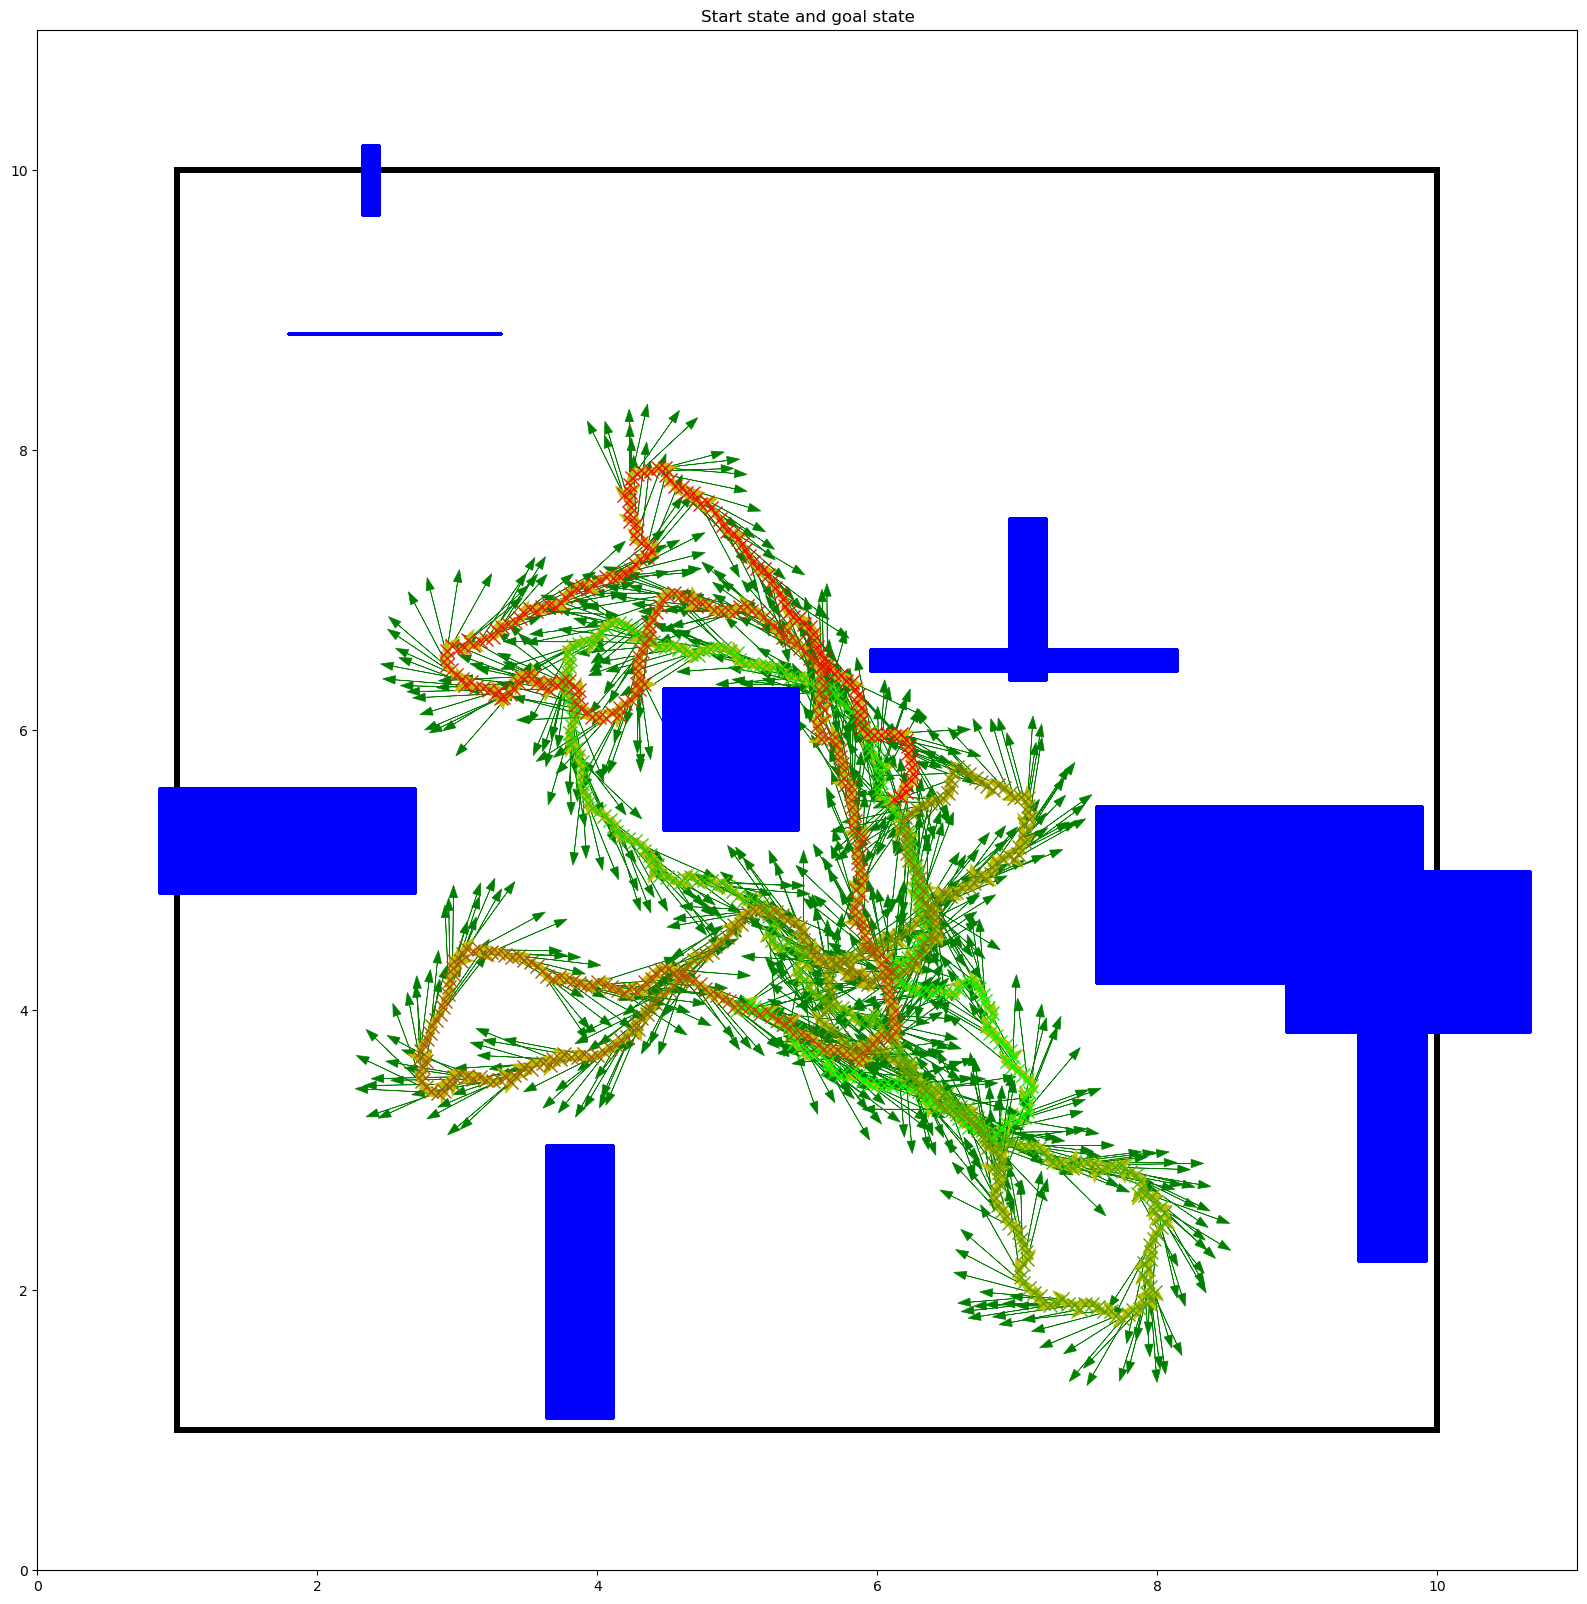

In [20]:
data_dict = {
    "x": pose_seq[:,0],
    "y": pose_seq[:,1],
    "t": pose_seq[:,2],
    "si": beamrs_seq
}

samples = beamrs_seq.shape[0]
plot_beams = False
text = "Start state and goal state"

plot_env(text, samples, data_dict, plot_beams, 0.5)